In [ ]:
!pip install scikit-learn catboost matplotlib pandas numpy streamlit requests joblib shap flask mpl-finance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1


In [ ]:
# Monter Google Drive dans Google Colab pour y accéder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Accéder au répertoire où se trouve le fichier "application_train.csv"
import os
os.chdir('/content/drive/My Drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# Charger les données
data_train = pd.read_csv('data_train.csv')


In [5]:
data_train

,SK_ID_CURR,TARGET,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,...,NONLIVINGAREA_MODE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,TOTALAREA_MODE,WALLSMATERIAL_MODE
0,100002,1,24700.5,406597.5,351000.0,0.0,1.0,0.0247,0.0250,0.0252,...,0.0000,8,5,0.018801,2,2,0,0,0.0149,5
1,100003,0,35698.5,1293502.5,1129500.0,0.0,0.0,0.0959,0.0968,0.0924,...,0.0000,3,39,0.003541,1,1,0,0,0.0714,0
2,100004,0,6750.0,135000.0,135000.0,0.0,0.0,NaN,NaN,NaN,...,NaN,8,11,0.010032,2,2,0,0,NaN,7
3,100006,0,29686.5,312682.5,297000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,8,5,0.008019,2,2,0,0,NaN,7
4,100007,0,21865.5,513000.0,513000.0,0.0,0.0,NaN,NaN,NaN,...,NaN,3,37,0.028663,2,2,0,1,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,27558.0,254700.0,225000.0,NaN,NaN,0.2021,0.2040,0.1008,...,0.0125,14,43,0.032561,1,1,0,0,0.2898,5
307507,456252,0,12001.5,269550.0,225000.0,NaN,NaN,0.0247,0.0250,0.0252,...,0.0000,18,57,0.025164,2,2,0,0,0.0214,5
307508,456253,0,29979.0,677664.0,585000.0,1.0,1.0,0.1031,0.1041,0.1050,...,0.0000,10,39,0.005002,3,3,0,1,0.7970,4
307509,456254,1,20205.0,370107.0,319500.0,0.0,0.0,0.0124,0.0125,0.0126,...,NaN,8,3,0.005313,2,2,1,1,0.0086,5


In [6]:

import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# supprimer la colonne 'TARGET'
X = data_train.drop(columns=['TARGET'])

# La variable y contiendra les valeurs de la colonne 'TARGET' du dataframe 'data_train'.
y = data_train['TARGET']

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'apprentissage et de test sans mélanger
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)


In [ ]:
# Enregistrer le dataframe 'X_train' au format CSV
X_train.to_csv('X_train.csv', index=False)

In [ ]:
X_test.columns.tolist()

['SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_EMP_PHONE',
 'FLAG_OWN_CAR',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FONDKAPREMONT_MODE',
 'HOUR_APPR_PROCESS_START',
 'HOUSETYPE_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVINGA

In [ ]:
X_train.columns.tolist()

['SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_EMP_PHONE',
 'FLAG_OWN_CAR',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FONDKAPREMONT_MODE',
 'HOUR_APPR_PROCESS_START',
 'HOUSETYPE_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVINGA

In [ ]:
X_train

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,...,NONLIVINGAREA_MODE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,TOTALAREA_MODE,WALLSMATERIAL_MODE
0,100002,24700.5,406597.5,351000.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,...,0.0000,8,5,0.018801,2,2,0,0,0.0149,5
1,100003,35698.5,1293502.5,1129500.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,...,0.0000,3,39,0.003541,1,1,0,0,0.0714,0
2,100004,6750.0,135000.0,135000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,8,11,0.010032,2,2,0,0,NaN,7
3,100006,29686.5,312682.5,297000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8,5,0.008019,2,2,0,0,NaN,7
4,100007,21865.5,513000.0,513000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,3,37,0.028663,2,2,0,1,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,384688,13500.0,270000.0,270000.0,NaN,NaN,0.3948,0.3987,0.4023,NaN,...,NaN,11,5,0.024610,2,2,0,0,0.5067,5
246004,384690,17046.0,311877.0,252000.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,18,57,0.020246,3,3,0,0,NaN,7
246005,384691,25321.5,254700.0,225000.0,0.0,2.0,0.1309,0.1322,0.1197,0.0889,...,0.0954,3,4,0.072508,1,1,0,0,0.0976,5
246006,384693,16447.5,177903.0,148500.0,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,4,55,0.035792,2,2,0,1,NaN,7


In [ ]:
X_test

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,...,NONLIVINGAREA_MODE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,TOTALAREA_MODE,WALLSMATERIAL_MODE
246008,384696,36553.5,545040.0,450000.0,NaN,NaN,0.1505,0.1520,0.1534,0.0913,...,0.0235,2,39,0.010643,2,2,0,0,0.1248,5
246009,384697,62613.0,790830.0,675000.0,NaN,NaN,0.2010,0.2030,0.2048,0.4545,...,0.0138,0,26,0.010006,2,1,0,0,0.2099,4
246010,384698,15232.5,310500.0,310500.0,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,8,42,0.026392,2,2,0,1,NaN,7
246011,384699,36643.5,942300.0,675000.0,1.0,0.0,0.0825,0.0833,0.0840,0.0818,...,0.0000,6,42,0.072508,1,1,0,0,0.0844,4
246012,384700,19957.5,272520.0,225000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,3,47,0.008575,2,2,0,1,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,27558.0,254700.0,225000.0,NaN,NaN,0.2021,0.2040,0.1008,0.0887,...,0.0125,14,43,0.032561,1,1,0,0,0.2898,5
307507,456252,12001.5,269550.0,225000.0,NaN,NaN,0.0247,0.0250,0.0252,0.0435,...,0.0000,18,57,0.025164,2,2,0,0,0.0214,5
307508,456253,29979.0,677664.0,585000.0,1.0,1.0,0.1031,0.1041,0.1050,0.0862,...,0.0000,10,39,0.005002,3,3,0,1,0.7970,4
307509,456254,20205.0,370107.0,319500.0,0.0,0.0,0.0124,0.0125,0.0126,NaN,...,NaN,8,3,0.005313,2,2,1,1,0.0086,5


In [ ]:
# Pipeline with imputation, SMOTE, and CatBoostClassifier
catboost_pipeline = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ("undersampler", RandomUnderSampler(sampling_strategy=0.2, random_state=0)),
    ("smote", SMOTE(sampling_strategy=0.3, random_state=0)),
    ('model', CatBoostClassifier(random_state=42))
])
# Utiliser cross_val_predict pour obtenir les prédictions de probabilités sur l'ensemble de test en utilisant la validation croisée
catboost_probs_cv = cross_val_predict(catboost_pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Calculer l'AUC-ROC pour les prédictions de probabilités de la validation croisée
auc_roc_cv = roc_auc_score(y_train, catboost_probs_cv)

# Entraîner le modèle CatBoost sur toutes les données d'entraînement
catboost_pipeline.fit(X_train, y_train)

# Prédire les probabilités sur l'ensemble de test pour le modèle CatBoost
catboost_probs = catboost_pipeline.predict_proba(X_test)[:, 1]

# Calculer l'AUC-ROC sur les prédictions de probabilités de l'ensemble de test
auc_roc_test = roc_auc_score(y_test, catboost_probs)
print("AUC-ROC (Test set):", auc_roc_test)
print("AUC-ROC (Cross-validated):", auc_roc_cv)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
6:	learn: 0.5012172	total: 885ms	remaining: 2m 5s
7:	learn: 0.4888770	total: 1.14s	remaining: 2m 21s
8:	learn: 0.4774001	total: 1.28s	remaining: 2m 20s
9:	learn: 0.4696120	total: 1.43s	remaining: 2m 21s
10:	learn: 0.4593439	total: 1.59s	remaining: 2m 23s
11:	learn: 0.4493354	total: 1.77s	remaining: 2m 25s
12:	learn: 0.4433779	total: 1.94s	remaining: 2m 27s
13:	learn: 0.4352455	total: 2.06s	remaining: 2m 25s
14:	learn: 0.4295710	total: 2.2s	remaining: 2m 24s
15:	learn: 0.4247531	total: 2.3s	remaining: 2m 21s
16:	learn: 0.4210313	total: 2.44s	remaining: 2m 20s
17:	learn: 0.4163865	total: 2.62s	remaining: 2m 22s
18:	learn: 0.4128153	total: 2.83s	remaining: 2m 26s
19:	learn: 0.4103558	total: 2.97s	remaining: 2m 25s
20:	learn: 0.4082666	total: 3.1s	remaining: 2m 24s
21:	learn: 0.4057447	total: 3.25s	remaining: 2m 24s
22:	learn: 0.4038942	total: 3.38s	remaining: 2m 23s
23:	learn: 0.4022392	total: 3.44s	remaining: 2

In [ ]:
import joblib
# Enregistrez le modèle dans un fichier
joblib.dump(catboost_pipeline, 'modele_catboost.pkl')


['modele_catboost.pkl']

In [ ]:
X_test_reduit = X_test.sample(n=20, random_state=42)

In [ ]:
X_test_reduit

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,...,NONLIVINGAREA_MODE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,TOTALAREA_MODE,WALLSMATERIAL_MODE
275898,419700,19125.0,382500.0,382500.0,10.0,1.0,NaN,NaN,NaN,NaN,...,NaN,18,7,0.030755,2,2,0,0,NaN,7
277989,422116,28786.5,679500.0,679500.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,18,5,0.030755,2,2,0,0,NaN,7
291686,437915,27333.0,473841.0,387000.0,0.0,3.0,0.0918,0.0926,0.0935,0.1063,...,0.0000,8,33,0.011657,1,1,0,0,0.0809,4
261441,402611,13500.0,270000.0,270000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,11,0.011657,1,1,0,0,NaN,7
270089,413015,46084.5,900000.0,900000.0,0.0,7.0,0.0082,0.0083,0.0084,NaN,...,0.0000,18,57,0.026392,2,2,0,0,0.0061,5
263169,404728,9000.0,180000.0,180000.0,0.0,2.0,NaN,NaN,NaN,NaN,...,NaN,14,5,0.010966,2,2,0,0,0.0071,5
299951,447488,27679.5,942300.0,675000.0,0.0,0.0,0.0041,0.0042,0.0042,0.0021,...,0.0000,18,5,0.046220,1,1,0,1,0.0033,5
290737,436814,51876.0,971280.0,900000.0,5.0,2.0,NaN,NaN,NaN,NaN,...,NaN,18,47,0.028663,2,2,0,1,NaN,7
266334,408548,22257.0,729792.0,630000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,18,57,0.006008,2,2,0,0,NaN,7
258917,399637,19431.0,396850.5,279000.0,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,3,2,0.035792,2,2,0,0,NaN,7


In [ ]:
# Enregistrer le dataframe 'X_test' au format CSV
X_test.to_csv('X_test.csv', index=False)

In [ ]:
# Enregistrer le dataframe 'X_test' au format CSV
X_test_reduit.to_csv('X_test_reduit.csv', index=False)

In [ ]:
X_test

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,...,NONLIVINGAREA_MODE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,TOTALAREA_MODE,WALLSMATERIAL_MODE
246008,384696,36553.5,545040.0,450000.0,NaN,NaN,0.1505,0.1520,0.1534,0.0913,...,0.0235,2,39,0.010643,2,2,0,0,0.1248,5
246009,384697,62613.0,790830.0,675000.0,NaN,NaN,0.2010,0.2030,0.2048,0.4545,...,0.0138,0,26,0.010006,2,1,0,0,0.2099,4
246010,384698,15232.5,310500.0,310500.0,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,8,42,0.026392,2,2,0,1,NaN,7
246011,384699,36643.5,942300.0,675000.0,1.0,0.0,0.0825,0.0833,0.0840,0.0818,...,0.0000,6,42,0.072508,1,1,0,0,0.0844,4
246012,384700,19957.5,272520.0,225000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,3,47,0.008575,2,2,0,1,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,27558.0,254700.0,225000.0,NaN,NaN,0.2021,0.2040,0.1008,0.0887,...,0.0125,14,43,0.032561,1,1,0,0,0.2898,5
307507,456252,12001.5,269550.0,225000.0,NaN,NaN,0.0247,0.0250,0.0252,0.0435,...,0.0000,18,57,0.025164,2,2,0,0,0.0214,5
307508,456253,29979.0,677664.0,585000.0,1.0,1.0,0.1031,0.1041,0.1050,0.0862,...,0.0000,10,39,0.005002,3,3,0,1,0.7970,4
307509,456254,20205.0,370107.0,319500.0,0.0,0.0,0.0124,0.0125,0.0126,NaN,...,NaN,8,3,0.005313,2,2,1,1,0.0086,5


In [ ]:
X_train

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,...,NONLIVINGAREA_MODE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,TOTALAREA_MODE,WALLSMATERIAL_MODE
0,100002,24700.5,406597.5,351000.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,...,0.0000,8,5,0.018801,2,2,0,0,0.0149,5
1,100003,35698.5,1293502.5,1129500.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,...,0.0000,3,39,0.003541,1,1,0,0,0.0714,0
2,100004,6750.0,135000.0,135000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,8,11,0.010032,2,2,0,0,NaN,7
3,100006,29686.5,312682.5,297000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8,5,0.008019,2,2,0,0,NaN,7
4,100007,21865.5,513000.0,513000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,3,37,0.028663,2,2,0,1,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,384688,13500.0,270000.0,270000.0,NaN,NaN,0.3948,0.3987,0.4023,NaN,...,NaN,11,5,0.024610,2,2,0,0,0.5067,5
246004,384690,17046.0,311877.0,252000.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,18,57,0.020246,3,3,0,0,NaN,7
246005,384691,25321.5,254700.0,225000.0,0.0,2.0,0.1309,0.1322,0.1197,0.0889,...,0.0954,3,4,0.072508,1,1,0,0,0.0976,5
246006,384693,16447.5,177903.0,148500.0,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,4,55,0.035792,2,2,0,1,NaN,7


In [7]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 14.1 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143855 sha256=cd17e886466d4bb564f0685fe94124ac1c8c606c291de2b9bbc053e54301f26a
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uni

AUC-ROC (Test set): 0.675479760045012


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


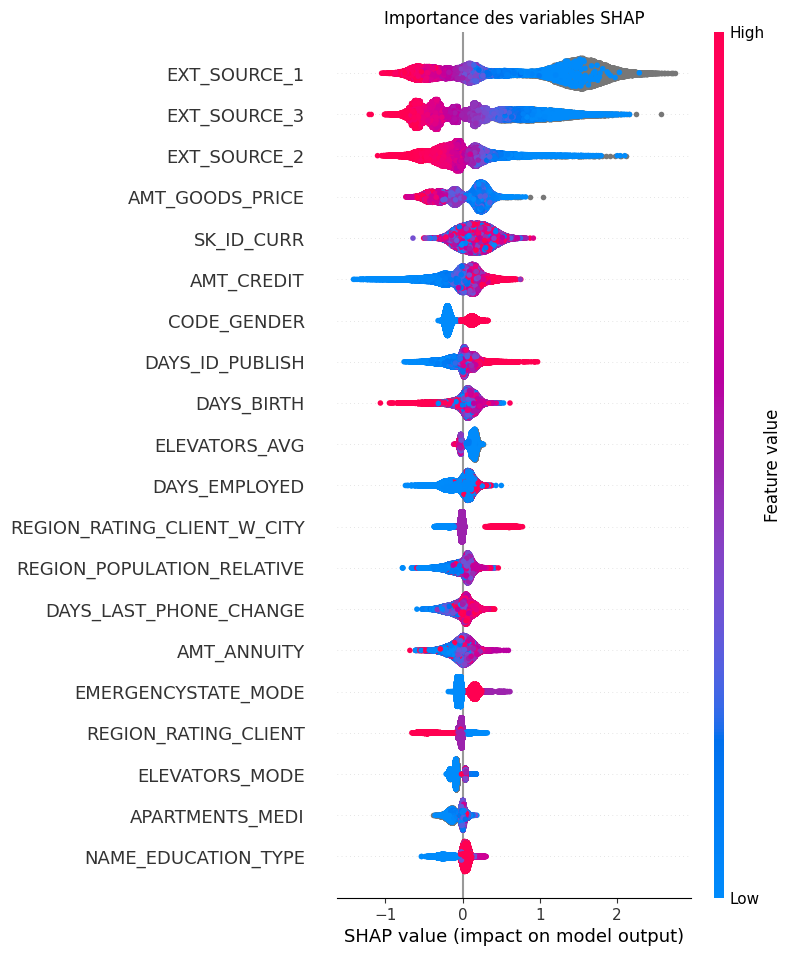

In [17]:
import mlflow
import shap
import joblib
import pickle
import matplotlib.pyplot as plt

# Charger le modèle CatBoost pré-entraîné
model_path = 'modele_catboost.pkl'
catboost_model = joblib.load(model_path)
catboost_model = catboost_model.named_steps['model']

# Calculer l'AUC-ROC sur les prédictions de probabilités de l'ensemble de test
catboost_probs = catboost_model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, catboost_probs)
print("AUC-ROC (Test set):", auc_roc_test)

# Calculer l'importance des variables SHAP
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Tracer un graphique pour visualiser l'importance des variables SHAP (pour une seule observation, ajustez l'indice)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Importance des variables SHAP")
plt.show()



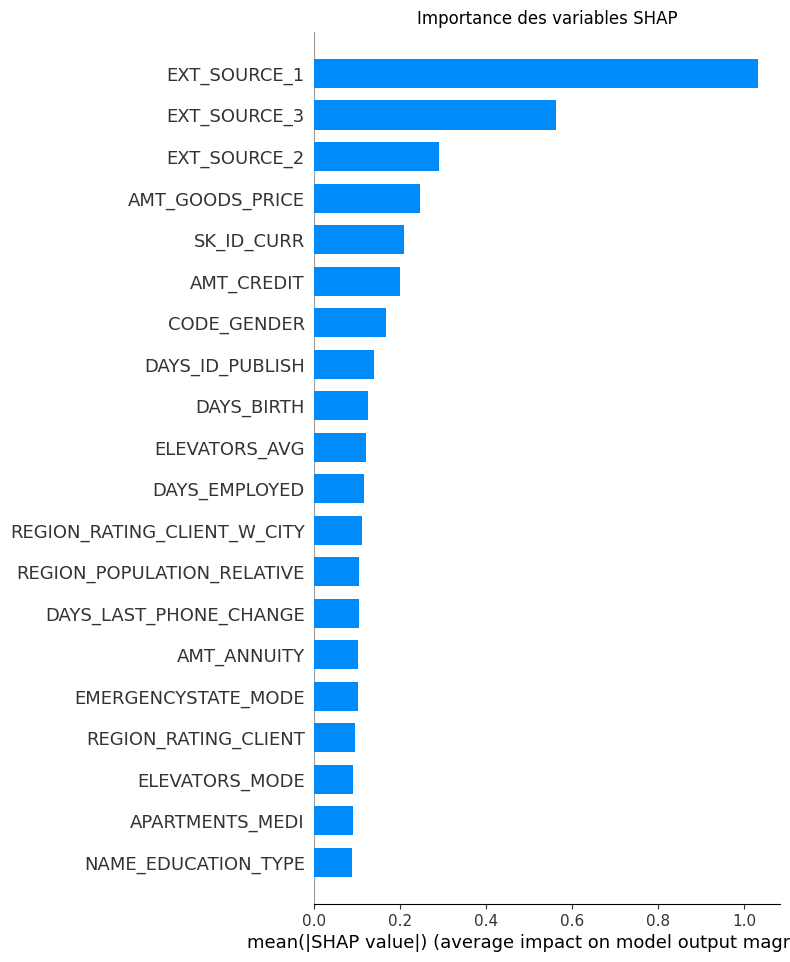

In [19]:

# Tracer un graphique de type "bar" pour visualiser l'importance des variables SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# Ajouter un titre au graphique
plt.title("Importance des variables SHAP")

# Afficher le graphique
plt.show()
